# Detecting SQL injections using BERT

# Install needed libraries

In [1]:
!pip install ktrain
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 73.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Prepari

# Importing the libraries

In [2]:
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle

# Reading and displaying the dataset

In [3]:
# Detect the encoding of the CSV file
with open('SQLiV3_3.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Read the CSV file into a pandas dataframe, using the detected encoding
df = pd.read_csv('SQLiV3_3.csv', sep=',',  encoding=result['encoding'])
# Display the first rows of the dataframe
print(df.head(10))

                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1
5  select * from users where id  =  1 +$+ or 1  =...      1
6  1;  (  load_file  (  char  (  47,101,116,99,47...      1
7   select * from users where id  =  '1' or ||/1 ...      1
8   select * from users where id  =  '1' or \.<\ ...      1
9                                    ? or 1  =  1 --      1


In [4]:
df.shape

(22599, 2)

In [5]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22599 entries, 0 to 22598
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  22599 non-null  object
 1   Label     22599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 353.2+ KB
----------------------------------------------------


In [6]:
df['Label'].describe()


count    22599.000000
mean         0.499624
std          0.500011
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

# Process NaN values

In [7]:
df['Label'].isna().sum() # Count NaN label values.


0

# The target label

In [8]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [9]:
df[df['Label'] == 1].count() # Count how much label are 1.


Sentence    11291
Label       11291
dtype: int64

In [10]:
df[df['Label'] == 0].count() # Count how much label are 0.


Sentence    11308
Label       11308
dtype: int64

# Distribution of the label

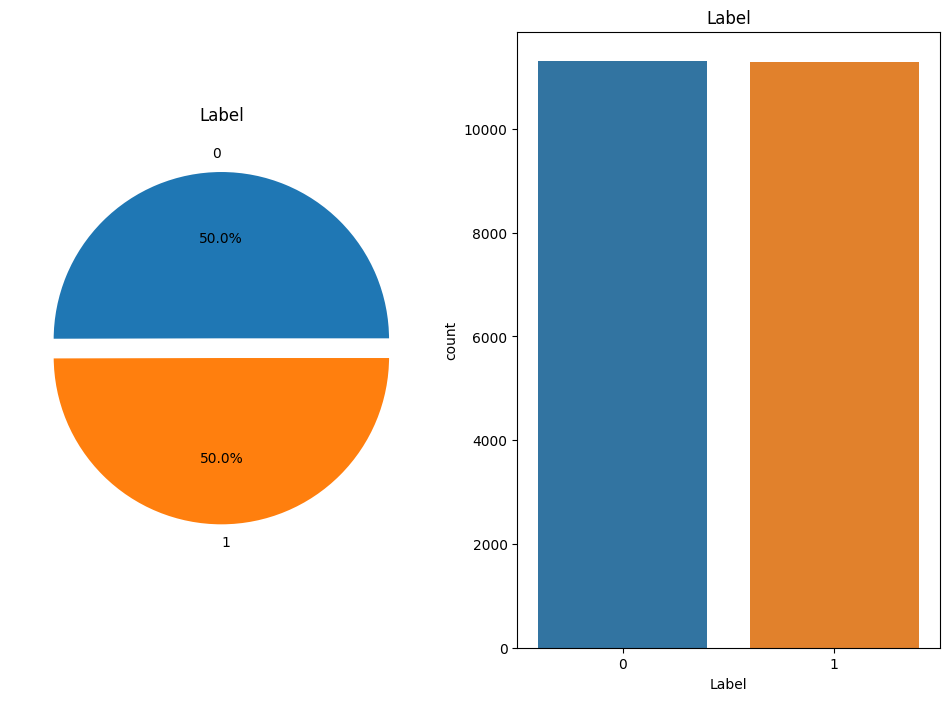

In [11]:
import matplotlib.colors as mcolors
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
df['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=df, ax=ax[1], palette=colors)
ax[1].set_title('Label')
plt.show()

# Creating the training and test sets

In [12]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences, labels,
                                                                       preprocess_mode='bert',
                                                                       maxlen=100,
                                                                      val_pct=0.2,
                                                                      class_names=list(set(labels))
                                                                      )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [13]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 100


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Fine-tuning the BERT model

In [14]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=32)

In [15]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
565/565 [==============================] - 437s 717ms/step - loss: 0.0548 - accuracy: 0.9877 - val_loss: 0.0015 - val_accuracy: 0.9993
Epoch 2/4
565/565 [==============================] - 413s 731ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 3/4
565/565 [==============================] - 413s 731ms/step - loss: 1.1950e-04 - accuracy: 0.9999 - val_loss: 0.0016 - val_accuracy: 0.9998
Epoch 4/4
565/565 [==============================] - 413s 731ms/step - loss: 3.0132e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9998


In [16]:
learner.validate(class_names=preproc.get_classes())


142/142 [==============================] - 37s 223ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2252
           1       1.00      1.00      1.00      2268

    accuracy                           1.00      4520
   macro avg       1.00      1.00      1.00      4520
weighted avg       1.00      1.00      1.00      4520



array([[2251,    1],
       [   0, 2268]])

In [17]:
learner.view_top_losses(n=30, preproc=preproc)

142/142 [==============================] - 32s 222ms/step
----------
id:2354 | loss:6.73 | true:0 | pred:1)

[CLS] select a . customer ##name as customer ##name ##1 , b . customer ##name as customer ##name ##2 , a . city ##fr ##om customers a , customers b ##w ##her ##e a . customer ##id < > b . customer ##id and a . city = b . city [SEP]


# Make predictions with the model

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make predictions
samples = [
     "1'; DROP TABLE users;--",
     "UPDATE customers SET phone_number = '555-555-5555' WHERE name = 'John Doe'",
     "SELECT COUNT(*) FROM users WHERE username = 'admin' OR 1 = 1",
     "UPDATE users SET password = 'newpassword' WHERE username = 'admin'" ,
     "select * from generate_series  (  5980,5980,case when   (  5980  =  5063  )   then 1 else 0 end  )   limit 1--",
     "SELECT TOP 3 * FROM growth SELECT * FROM catch 3SELECT * FROM mainly",
     "select * from users where id  =  1 or 1#",
     "INSERT INTO column ( white, does, certain, curious, first, our )  VALUES  ( 'rose', 'anyone'. close', 'remove', 'force', 'feet', 'fell' )",
     "SELECT * FROM users WHERE username = '' OR 1=1 --' AND password = 'input_password'"]
prediction = predictor.predict(samples)
print(prediction)

[1, 0, 1, 0, 1, 0, 1, 0, 1]


# Save Trained Model

In [19]:
with open('final_modelz.pkl', 'wb') as f:
    pickle.dump(predictor, f)

# Plotting the training and validation loss

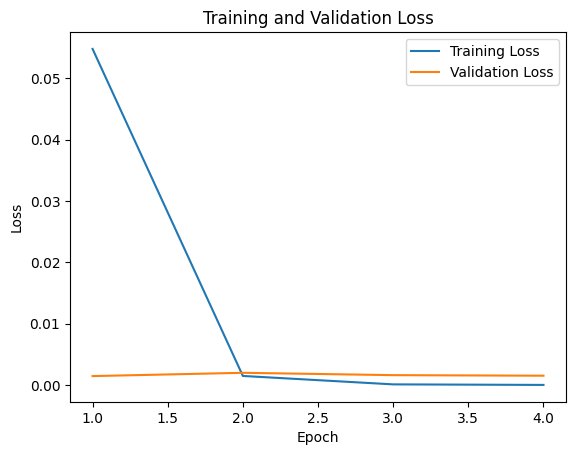

In [20]:
train_loss = learner.history.history['loss']
val_loss = learner.history.history['val_loss']

# Plot the training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the Model on a new unseen samples

In [32]:
normal_queries = [
    "DELETE FROM users WHERE id = 123;",
    "SELECT * FROM users WHERE id = 123",
    "SELECT * FROM users WHERE id IN (SELECT user_id FROM purchases WHERE purchase_date >= DATE_SUB(NOW(), INTERVAL 30 DAY))",
    "UPDATE users SET password = 'newpassword' WHERE username = 'admin'" ,
    "SELECT city, AVG(age) as avg_age FROM users GROUP BY city",
    "SELECT * FROM users WHERE name = 'John'",
    "SELECT u.id, u.name, SUM(p.amount) as total_purchase FROM users u JOIN purchases p ON u.id = p.user_id GROUP BY u.id, u.name ORDER BY total_purchase DESC LIMIT 5",
    "INSERT INTO column ( white, does, certain, curious, first, our )  VALUES  ( 'rose', 'anyone'. close', 'remove', 'force', 'feet', 'fell' )",
    "SELECT * FROM users ORDER BY registration_date DESC",
    "SELECT u.* FROM users u WHERE NOT EXISTS (SELECT c.id FROM categories c WHERE NOT EXISTS (SELECT p.id FROM purchases p WHERE p.category_id = c.id AND p.user_id = u.id))"
]
sql_injections = [
     "1'; DROP TABLE users;--",
     "1 and ascii ( lower ( substring  (  (  select top 1 name from sysobjects where xtype = 'u' ) , 1, 1  )  )   )  > 116",
     "anything' or 'x' = 'x",
     " )  union select * from information_schema.tables;",
     "x' AND members.email IS NULL; --",
     "SELECT COUNT(*) FROM users WHERE username = 'admin' OR 1 = 1",
     "select * from generate_series  (  5980,5980,case when   (  5980  =  5063  )   then 1 else 0 end  )   limit 1--",
     "select * from users where id  =  1 or 1#",
     "SELECT * FROM users WHERE username = '' OR 1=1 --' AND password = 'input_password'",
     "' AND 1 = utl_inaddr.get_host_address  (  (  SELECT DISTINCT ( granted_role )  FROM  ( SELECT DISTINCT ( granted_role ) , ROWNUM AS LIMIT FROM dba_role_privs WHERE GRANTEE = SYS.LOGINUSER )  WHERE LIMIT = 7  )  )   AND 'i' = 'i"]
prediction_1 = predictor.predict(normal_queries)
print(prediction_1)
prediction_2 = predictor.predict(sql_injections)
print(prediction_2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Test the model on a new dataset contains Only SQL injections

In [31]:
with open('sqli.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Read the CSV file into a pandas dataframe, using the detected encoding
dataset = pd.read_csv('sqli.csv', sep=',',  encoding=result['encoding'],nrows=1100)


# Separate queries and labels
queries = dataset['Sentence'].tolist()
labels = dataset['Label'].tolist()

#Checking similarity between the train dataset and the test dataset

In [24]:
with open('sqli.csv', 'rb') as f:
    resultt = chardet.detect(f.read())
# Load the first CSV file
df1 = pd.read_csv('sqli.csv', sep=',',  encoding=resultt['encoding'],nrows=1100)
with open('SQLiV3_3.csv', 'rb') as f:
    result = chardet.detect(f.read())
# Load the second CSV file
df2 = pd.read_csv('SQLiV3_3.csv', sep=',',  encoding=result['encoding'])

# Extract the "sentences" column from each DataFrame
sentences1 = set(df1['Sentence'].tolist())
sentences2 = set(df2['Sentence'].tolist())

# Find the common sentences
common_sentences = sentences1.intersection(sentences2)

# Calculate the percentage of common sentences in the first dataset
similarity_percentage = (len(common_sentences) / len(sentences1)) * 100

# Print the similarity percentage
print(f"Similarity Percentage: {similarity_percentage}%")

Similarity Percentage: 9.483667017913593%


In [25]:
# Count the number of common sentences
common_sentence_count = len(common_sentences)
# Print the count of common sentences
print(f"Number of Common Sentences: {common_sentence_count}")

Number of Common Sentences: 90


#Testing

In [33]:
correct_predictions = 0
total_queries = len(queries)
for query, label in zip(queries, labels):
    if not isinstance(query, str):
        query = str(query)
    prediction = predictor.predict(query)
    if prediction == label:
        correct_predictions += 1

accuracy = correct_predictions / total_queries
print(f"Accuracy: {accuracy}")

Accuracy: 0.9981818181818182


In [34]:
print(total_queries)
print(correct_predictions)

1100
1098
